## Load Module

In [1]:
import tensorflow as tf
import tensorflow.contrib.layers as ly
import os 
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as scio
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import shutil

## Parameters

In [2]:
# Inputs:Global parameters 
batch_size = 32
img_dim = 688
z_dim = 110
y_dim = 1

# Optimizer: whether use adam for parameters update , if flag is set false use tf.train.RMEPropOptimzer
is_adam = True
learning_rate_gen = 2e-4
learning_rate_dis = 2e-4
# the upper bound and lower bound in critic
clamp_lower =-0.01
clamp_upper = 0.01


# Train : Prameters
max_iter_step = 10000
device = '/gpu:0'
data_format = 'NCHW'
channel = 1
# Updata Diters times for critic in one iter(unless i<25 or i %500==0, i is the iterstep)
Riters = 10
Diters = 5
Diters = int(((Riters+1)/Riters*Diters))

# directory to store log ,include loss  and grad_norm of generator and critic
rgan_dir = './Inproved_rgan/Experient_1'
log_dir = rgan_dir + '/log_rgan'
ckpt_dir = rgan_dir + '/ckpt_rgan'
spec_dir = rgan_dir + '/spec_rgan'

if not os.path.exists(log_dir):
    os.makedirs(log_dir)
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)
else:
    shutil.rmtree(ckpt_dir)
    os.makedirs(ckpt_dir)
    
if not os.path.exists(spec_dir):
    os.makedirs(spec_dir)
else:
    shutil.rmtree(spec_dir)
    os.makedirs(spec_dir)

## Load dataset

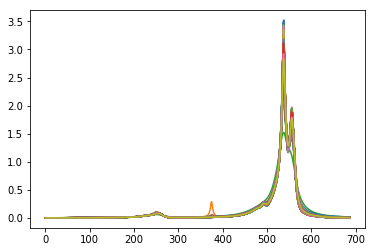

In [3]:
# from database load the data and label,clip the length network required
spect = scio.loadmat('NMR_Index.mat')
x,y = spect['NMR'],spect['Index'][:,3]
if x.shape[1]>img_dim:
    x = x[:,:img_dim]
# plot raw data    
plt.plot(x.transpose())
plt.show()

# pre_processing by minmaxmap
xmin, xmax, ymin, ymax = x.min(),x.max(), y.min(),y.max()
x,y = (x - xmin)/( xmax - xmin ),(y - ymin)/( ymax - ymin )

# reshape the data to the format that look like image
x= x.reshape(-1,1,img_dim,1)

## Generator

In [4]:
def generator_conv(z):
    train = ly.fully_connected(z, 1024, activation_fn = tf.nn.relu, normalizer_fn=None)
    train = ly.fully_connected(train,256*172,activation_fn = tf.nn.relu,normalizer_fn =None)
    train = tf.reshape(train,(-1,256,172,1))
    train = ly.conv2d_transpose(train, 128, kernel_size=[5,1],stride=[2,1],data_format=data_format,
                                activation_fn = tf.nn.relu, normalizer_fn = ly.batch_norm, padding='SAME',
                                normalizer_params={'fused':True,'data_format':data_format,},
                                weights_initializer = tf.random_normal_initializer(0,0.02))
    train = ly.conv2d_transpose(train, 64, kernel_size=[5,1],stride=[2,1],data_format=data_format,
                                activation_fn = tf.nn.relu, normalizer_fn = ly.batch_norm, padding='SAME',
                                normalizer_params={'fused':True,'data_format':data_format,},
                                weights_initializer = tf.random_normal_initializer(0,0.02))
    
    train = ly.conv2d_transpose(train, channel , kernel_size=[5,1],stride=[1,1],data_format=data_format,
                                activation_fn = tf.nn.tanh, padding='SAME',
                                weights_initializer = tf.random_normal_initializer(0,0.02))
    return train

## Discriminator

In [5]:
def lrelu(x,leak=0.2,name='lrelu'):
    with tf.variable_scope('lrelu'):
        f1 = 0.5*(1+leak)
        f2 = 0.5*(1-leak)
        return f1*x + f2*abs(x)

In [6]:
def critic_conv(x,reuse=False):
    with tf.variable_scope('discriminator') as scope:
        if reuse:
            scope.reuse_variables()
        size = 16
        
        img = ly.conv2d(x,num_outputs=size*4,kernel_size=[10,1],stride=[2,1],padding='SAME',
                       activation_fn = lrelu,data_format=data_format,
                       weights_initializer = tf.random_normal_initializer(0,0.02))
    
        img = ly.conv2d(img,num_outputs= size*8,kernel_size=[10,1],stride=[2,1],padding='SAME',
                        activation_fn = lrelu,data_format=data_format,normalizer_fn = ly.batch_norm,
                        normalizer_params ={'fused':True,'data_format':data_format},
                        weights_initializer = tf.random_normal_initializer(0,0.02))
       
        img = ly.conv2d(img,num_outputs= size*16,kernel_size=[10,1],stride=[2,1],padding='SAME',
                        activation_fn = lrelu,data_format=data_format,normalizer_fn = ly.batch_norm,
                        normalizer_params ={'fused':True,'data_format':data_format},
                        weights_initializer = tf.random_normal_initializer(0,0.02))
        
        img = tf.reshape(img,[batch_size,-1])
        # fully_connected
        img = ly.fully_connected(img,1024,activation_fn=lrelu)
        disc = ly.fully_connected(img,1,activation_fn=None)
    
    return disc

## Build Graph & Loss Function

In [7]:
def build_graph(is_test=False):
    ##########################  Inputs ######################################
    # real data 
    real_data = tf.placeholder(dtype = tf.float32,shape=[batch_size,channel,img_dim,1])

    
    # Noise
    z = tf.placeholder(dtype =tf.float32,shape =[batch_size,z_dim])

    #########################  End Inputs #####################################
    
    ##########################  Graph   ######################################
    generator = generator_conv
    discriminator = critic_conv
    
    with tf.variable_scope('generator'):
        gen = generator(z)
    
    disc_real = discriminator(real_data)
    disc_fake = discriminator(gen, reuse=True)

    # Wasserstein distance
    d_loss = tf.reduce_mean(disc_fake - disc_real)
    g_loss = tf.reduce_mean( - disc_fake)
    g_loss_summ = tf.summary.scalar('wasserstein_loss_g' , g_loss)
    d_loss_summ = tf.summary.scalar('wasserstein_loss_d' , -d_loss)
     
    # Loss of Discriminator and Generator, Discriminator train on True and False data
    loss_gen = g_loss
    loss_dis = d_loss
    
    loss_gen_summ = tf.summary.scalar('generator_loss',loss_gen)
    loss_dis_summ = tf.summary.scalar('discriminator_loss',loss_dis)
    ########################### End Graph   ######################################
    if is_test:
        return gen,regr_real,z_reg,z_rand,real_data
    
    ##################### Optimization ########################################
    # Variable Collection
    theta_g = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,scope='generator')
    theta_d = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,scope='discriminator')

    # Optimizers
    counter_g = tf.Variable(trainable=False , initial_value=0,dtype=tf.int32)
    opt_g = optimize(loss = loss_gen,variables=theta_g, learning_rate = learning_rate_gen,
                    optimizer=tf.train.AdamOptimizer if is_adam is True else tf.train.RMSPropOptimizer,
                    global_step=counter_g,summaries=['gradient_norm','gradients'])
    
    counter_d = tf.Variable(trainable=False , initial_value=0,dtype=tf.int32)
    opt_d = optimize(loss =loss_dis,variables=theta_d ,learning_rate = learning_rate_dis,
                    optimizer=tf.train.AdamOptimizer if is_adam is True else tf.train.RMSPropOptimizer,
                    global_step=counter_d,summaries=['gradient_norm','gradients'])
    
    # Clip weights
    clipped_var_d = [tf.assign(var,tf.clip_by_value(var,clamp_lower,clamp_upper)) for var in theta_d]
    with tf.control_dependencies([opt_d]):
        opt_d = tf.tuple(clipped_var_d)
    ################################# End Optimization ################################################
    return opt_d, opt_g ,real_data,z ,loss_dis,loss_gen,gen

####  Optimizer

In [8]:
def optimize(loss,learning_rate, optimizer,variables,global_step,summaries):
    optim = optimizer(learning_rate=learning_rate)
    
    # Caculate gradients
    gradients = optim.compute_gradients(loss,var_list = variables)
    
    # Add summary
    if summaries is None:
        summaries = ['loss','learning_rate']
    if 'gradient_norm'  in summaries:
        tf.summary.scalar('global_norm/gradient_norm',tf.global_norm(list(zip(*gradients))[0]))
        
    if 'loss' in summaries:
        tf.summary.scalar('loss',loss)
    
    for gradient,variable in gradients:
        if isinstance(gradient,tf.IndexedSlices):
            grad_values = gradient.values
        else:
            grad_values = gradient
        
        if grad_values is not None:
            var_name = variable.name.replace(':','_')
            if 'gradients' in summaries:
                tf.summary.histogram('gradients/%s'%var_name, grad_values)
            
            if 'gradient_norm' in summaries:
                tf.summary.scalar('gradient_norm/%s'%var_name,tf.global_norm([grad_values]))
    return optim.apply_gradients(gradients,global_step=global_step)
        

## Plot

In [9]:
def save_spectrum(gen, i,is_show=False):
    batch_size = 10
    gen = gen[:batch_size]
    
    
    # control the spect limitation and intv determine the the distance of spectrums
    intv = 0
    scale = 3.9
    # extend along y axis to visulize the difference between spetrum
    if is_show:
        extd = np.matlib.repmat(np.arange(0,batch_size),img_dim,1) 
        extd = extd * scale*intv
    else:
        extd = np.zeros((img_dim, batch_size))
    # convert data to ideal format    
    spec = gen.reshape(batch_size,img_dim)*(xmax-xmin)+ xmin
    spec = spec.transpose() + extd
    
    # plot the spectrum with ylimit legend and other thing
    plt.figure(figsize=(10,8))
    plt.plot(np.arange(spec.shape[0]),spec ,'-*')
    plt.ylim((-0.5,scale))
    #plt.legend([np.array_str(var) for var in np.arange(batch_size)])
    
    if is_show:
        return plt.show()
    # savefig
    plt.savefig(spec_dir+'/'+str(i).zfill(4)+'.png')
    plt.close('all')

## Condictional WGAN Subphase 

In [10]:
def train_wgan(max_iters = 1000):
    with tf.device(device):
        opt_d, opt_g ,real_data,z,loss_dis,loss_gen,gen = build_graph()
    
    def next_feed_dict(iter, shuffled = False):
        if shuffled:
            idx = np.random.randint(x.shape[0],size=(batch_size,))
        else:
            bat_num = int(x.shape[0]/batch_size)
            par = int(1 % bat_num)
            idx = np.arange(x.shape[0])[par * batch_size:(par+1)*batch_size]

        train_img,train_label = x[idx],y[idx].reshape(batch_size,y_dim)
        # False data which sigma = 0.3 mean most of point located in the [-1,1].
        batch_z_rand = np.random.normal(0,0.3,[batch_size,z_dim]).astype(np.float32)
            
        feed_dict = {real_data:train_img, z:batch_z_rand}
        return feed_dict
    
    config = tf.ConfigProto(allow_soft_placement = True,log_device_placement=True)
    config.gpu_options.allow_growth =True
    config.gpu_options.per_process_gpu_memory_fraction=0.9
    
    with tf.Session(config=config) as sess:
        sess.run(tf.global_variables_initializer())

        d_loss, g_loss=[], []
        for i in range(max_iters):
            feed_dict = next_feed_dict(i)
            # training discriminator
            _,loss_of_dis = sess.run([opt_d,loss_dis],feed_dict = feed_dict)
            _,loss_of_gen,spec = sess.run([opt_g,loss_gen,gen],feed_dict = feed_dict)
            
            d_loss.append(loss_of_dis)
            g_loss.append(loss_of_gen)
            if i % 100 == 0:
                print('the loss of discriminator is %0.3f'%loss_of_dis)
                save_spectrum(spec, i)
                print('the loss of generator is %0.3f'%loss_of_gen)
                
    return  d_loss,g_loss  
    

In [11]:
tf.reset_default_graph()
max_iters = 20000
d_loss,g_loss = train_wgan(max_iters =max_iters )

the loss of discriminator is 0.005
the loss of generator is 0.530
the loss of discriminator is -274.544
the loss of generator is 161.135
the loss of discriminator is -385.666
the loss of generator is 129.182
the loss of discriminator is -836.872
the loss of generator is 440.594
the loss of discriminator is -395.964
the loss of generator is 197.056
the loss of discriminator is -649.820
the loss of generator is 268.175
the loss of discriminator is -614.204
the loss of generator is 278.884
the loss of discriminator is -562.613
the loss of generator is 231.812
the loss of discriminator is -24.932
the loss of generator is -407.691
the loss of discriminator is 7.102
the loss of generator is 351.140
the loss of discriminator is -48.293
the loss of generator is 244.349
the loss of discriminator is 2.131
the loss of generator is 11.404
the loss of discriminator is -339.232
the loss of generator is 131.291
the loss of discriminator is -661.952
the loss of generator is 279.730
the loss of discrim

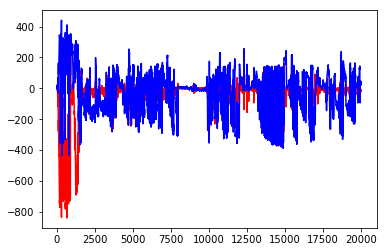

In [12]:
d_loss,g_loss = [np.array(var) for var in(d_loss,g_loss)]    
plt.plot(np.arange(max_iters),d_loss,'-r',np.arange(max_iters),g_loss,'-b')
plt.show()

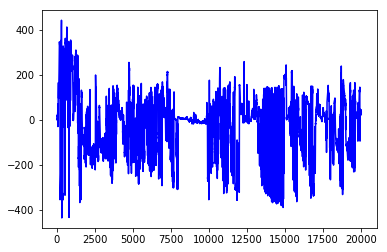

In [14]:
plt.plot(np.arange(max_iters),g_loss,'-b')
plt.show()

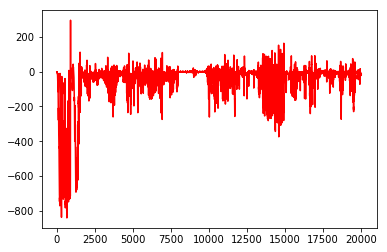

In [13]:
plt.plot(np.arange(max_iters),d_loss,'-r')
plt.show()